In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [3]:
# 假设所有Excel文件都存放在一个文件夹中
folder_path = './'  # 替换为你的文件夹路径
file_names = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

# 读取所有Excel文件并存储为DataFrame对象
dfs = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_excel(file_path)
    dfs.append(df)

# 使用concat合并所有DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# 将合并后的数据写入新的Excel文件
output_file_path = 'merged_green500.xlsx'  # 输出文件的路径和名称
merged_df.to_excel(output_file_path, index=False)

In [5]:
# 1. 读取CSV文件
df = pd.read_excel('merged_green500.xlsx')

In [29]:
from sklearn.linear_model import LinearRegression
# 其中'Optimized Run (Peak Power)' 'Power (kW)'列有很多NaN值
# 直接按照 Rmax Rpeak 来拟合了

# 分割数据为有观测值和无观测值两部分
df_with_obs = df.dropna(subset=['Optimized Run (Peak Power)'])
df_without_obs = df[df['Optimized Run (Peak Power)'].isna()]

# 建立回归模型
model = LinearRegression()

# 使用有观测值的数据训练模型
X = df_with_obs[['Rpeak [TFlop/s]']]  # 自变量
y = df_with_obs['Optimized Run (Peak Power)']   # 因变量
model.fit(X, y)

# 预测缺失的观测功耗
predicted_power = model.predict(df_without_obs[['Rpeak [TFlop/s]']])
print(type(predicted_power))

predicted_series = pd.Series(predicted_power, index=df_without_obs.index)

# 将预测值填充到原始DataFrame中
df['Optimized Run (Peak Power)'] = df['Optimized Run (Peak Power)'].fillna(predicted_series)

# 查看结果
print(df)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [7]:
# 2. 计算每个洲的平均功耗
avg_power = df.groupby('Continent')['Optimized Run (Peak Power)'].mean().reset_index()

# 3. 加载世界地图数据
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5244\1615107504.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [8]:
# 4. 合并平均功耗数据与地图数据
world = world.merge(avg_power, how='left', left_on='continent', right_on='Continent')


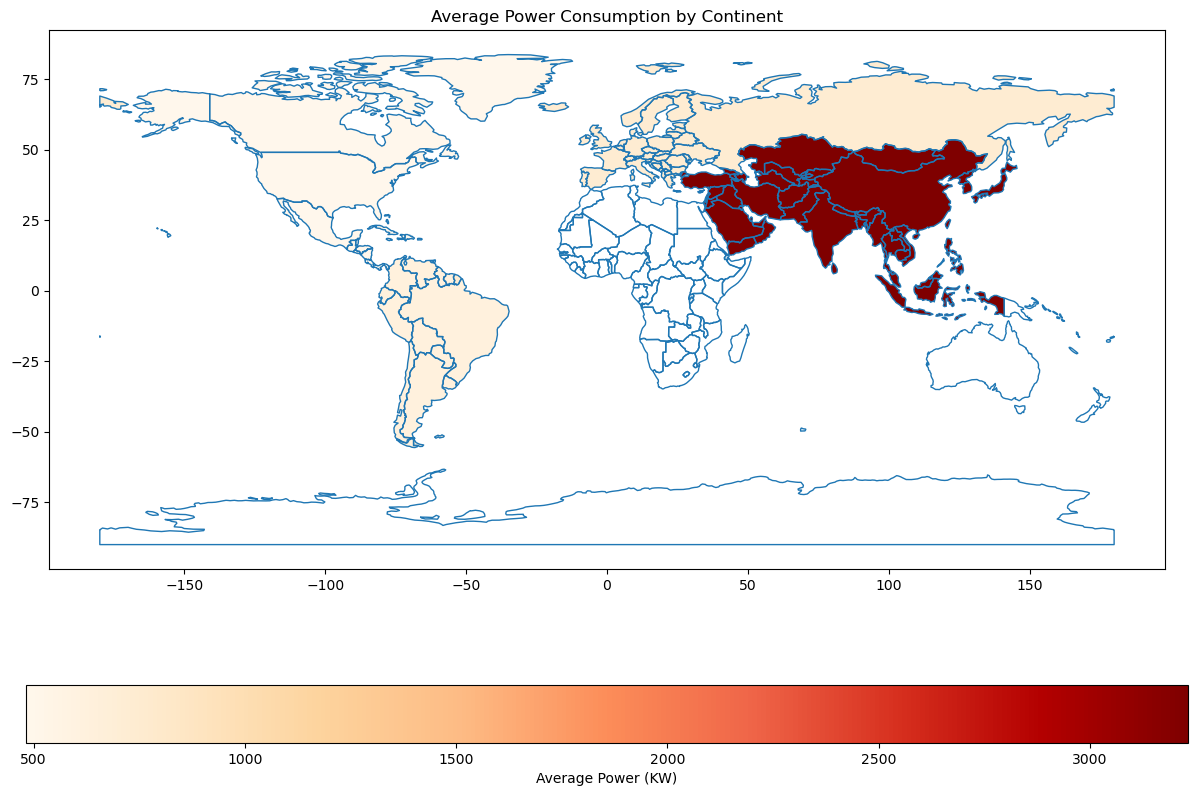

In [9]:
# 5. 绘制平均功率地图
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='Optimized Run (Peak Power)', ax=ax, legend=True,
           legend_kwds={'label': "Average Power (KW)",
                        'orientation': "horizontal"},
           cmap='OrRd')

plt.title('Average Power Consumption by Continent')
plt.show()

TypeError: can only concatenate str (not "float") to str

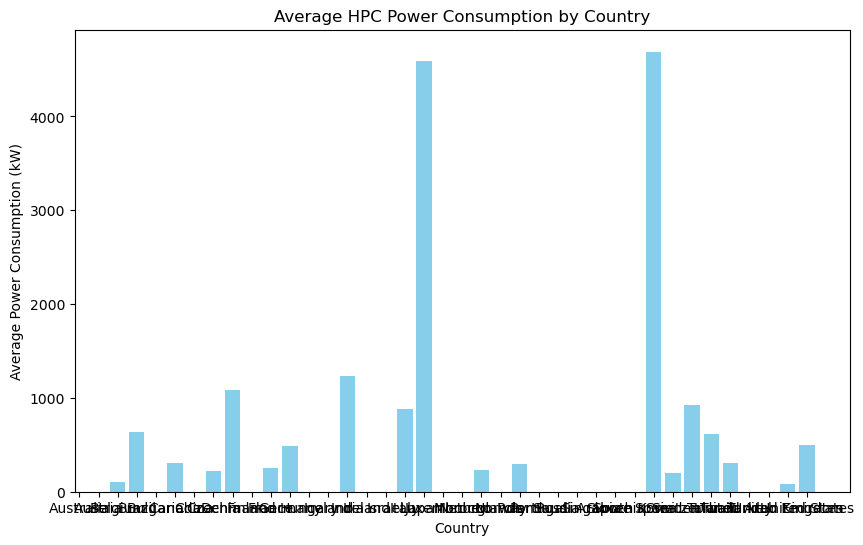

In [22]:
avg_power = df.groupby('Country')['Optimized Run (Peak Power)'].mean().reset_index()

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.bar(avg_power['Country'], avg_power['Optimized Run (Peak Power)'], color='skyblue')

# 设置图表标题和坐标轴标签
plt.title('Average HPC Power Consumption by Country')
plt.xlabel('Country')
plt.ylabel('Average Power Consumption (kW)')

# 显示数值标签
for i, power in enumerate(avg_power):
    plt.text(i, power + 0.05, str(power), ha='center')

# 显示图表
plt.show()